In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%pylab inline

import numpy as np
import sklearn
import pandas as pd
from sklearn.decomposition import PCA
import os

env_var = os.environ
os.environ["LACE_REPO"] = "/nfs/pic.es/user/l/lcabayol/DESI/LaCE"
os.environ["LACE_MANAGER_REPO"] = "/nfs/pic.es/user/l/lcabayol/DESI/LaCE_manager"

import matplotlib.pyplot as plt
# make pretty plots
font = {'size'   : 12}
matplotlib.rc('font', **font)
plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'cm'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# our modules
from lace.emulator import gp_emulator
from lace.cosmo import camb_cosmo
from lace.cosmo import fit_linP
from lace.emulator import poly_p1d
from lace.emulator import pd_archive



# read eBOSS P1D to plot relative error bars
from lace_manager.data import data_Chabanier2019
chab=data_Chabanier2019.P1D_Chabanier2019()

# Set up cosmology to get eBOSS k_max at each z where we have data
cosmo_fid=camb_cosmo.get_cosmology()

 /data/astro/scratch/lcabayol/anaconda3/envs/DESIenv6/lib/python3.10/site-packages/lace-1.0.1-py3.10.egg/lace/emulator/pd_archive.py:210: SyntaxWarning:"is" with a literal. Did you mean "=="?
 /data/astro/scratch/lcabayol/anaconda3/envs/DESIenv6/lib/python3.10/site-packages/lace-1.0.1-py3.10.egg/lace/emulator/pd_archive.py:210: SyntaxWarning:"is" with a literal. Did you mean "=="?


In [3]:
def sigma68(data,ax): return 0.5*(np.nanquantile(data,q = 0.84,axis = ax) - np.nanquantile(data,q = 0.16,axis = ax))


## TEST POLYNOMIAL DEGREE

In [16]:
from lace.emulator import poly_p1d

kmax_Mpc_test= 8
Nsim=30
p1d_fit_err = np.zeros(shape=(30,11,6,85))
for simnum in range(Nsim):
    
    truth=pd_archive.archivePD(z_max=4.5,pick_sim='diffseed')
    truth.average_over_samples(flag="all")
    truth = [d for d in truth.data_av_all if d['ind_tau'] == 1] 
    
    for aa,item in enumerate(truth):
    
        kMpc =item["k_Mpc"]
        k_mask=(kMpc<kmax_Mpc_test)&(kMpc>0)
        true_p1d=item["p1d_Mpc"][k_mask]#[:self.Nk_test]

        kMpc = kMpc[k_mask]

        for d in range(4,10):

            fit_p1d = poly_p1d.PolyP1D(kMpc,true_p1d, kmin_Mpc=1.e-3,kmax_Mpc=kmax_Mpc_test,deg=d)
            true_p1d_fit = fit_p1d.P_Mpc(kMpc)
            
            p1d_fit_err[simnum, aa, d-4] = true_p1d_fit / true_p1d
            
        

In [17]:
p1d_fit_err = (p1d_fit_err-1)*100
p1d_fit_err_z = p1d_fit_err.mean(0)

In [18]:
# make pretty plots

font = {'size'   : 14}
matplotlib.rc('font', **font)
plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'cm'

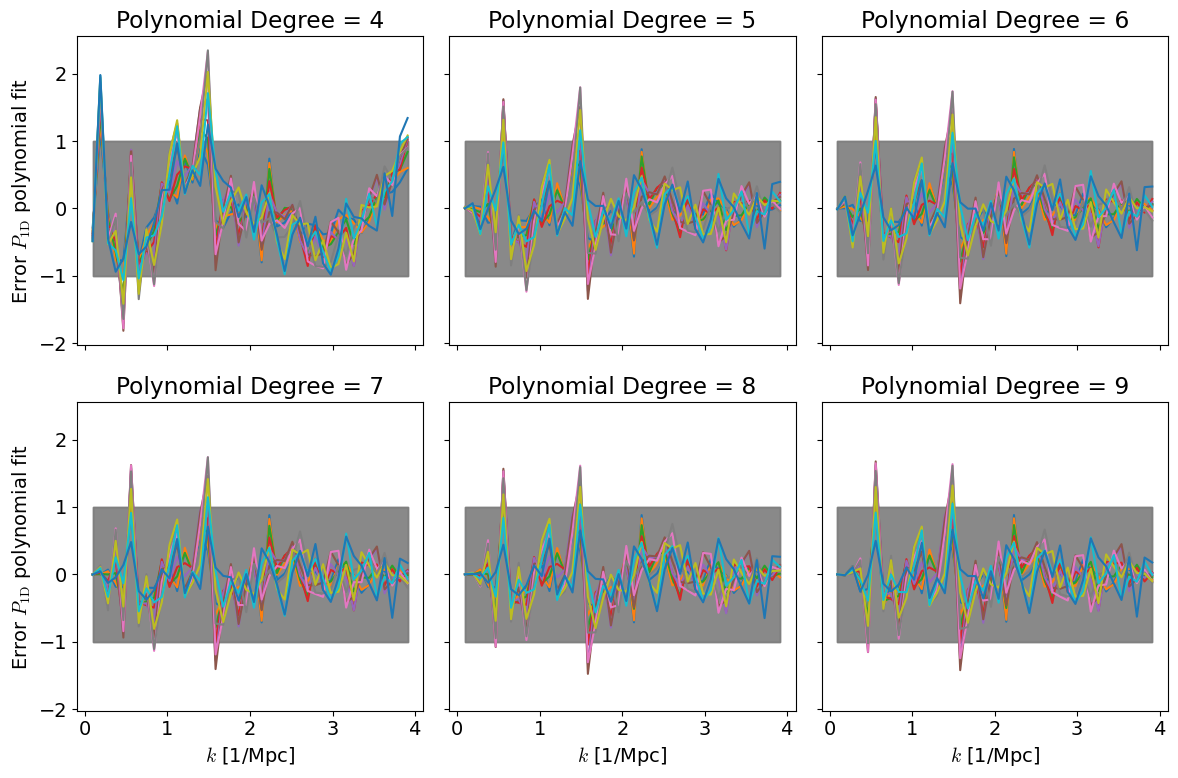

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,8), sharex=True, sharey=True)

for i in range(6):
    row = i // 3
    col = i % 3
    for z in range(11):
        ax[row,col].plot(kMpc, p1d_fit_err_z[z,i,:])
        ax[row,col].fill_between(kMpc, -1, 1, alpha=0.2, color='gray')
        
    degree = i + 4
    title = f'Polynomial Degree = {degree}'
    ax[row,col].set_title(title)
    
    
    if row == 1:
        ax[row,col].set_xlabel(r'$k$ [1/Mpc]')
    if col == 0:
        ax[row,col].set_ylabel(r'Error $P_{\rm 1D}$ polynomial fit')

plt.tight_layout()
plt.show()


In [19]:
p1d_fit_err_8 = p1d_fit_err_z.mean(0)
kMpc_8 = kMpc.copy()

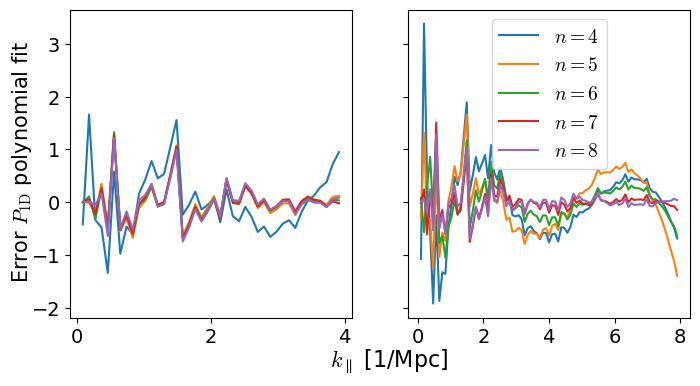

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4), sharex=False, sharey=True)
for i in range(5):
    degree = i + 4
    ax[0].plot(kMpc_4,p1d_fit_err_4[i], label =f'$n={degree}$')
    ax[1].plot(kMpc_8,p1d_fit_err_8[i], label =f'$n={degree}$')
ax[1].legend()
ax[1].set_xticks(np.arange(0,8.1,2))
#ax[0].set_yticks(np.arange(-0.015,0.011,0.005))
#ax[0].set_yticklabels(np.round(np.arange(-0.015,0.011,0.005),3), fontsize = 11)

fig.text(0.45, 0, r'$k_{\parallel}$ [1/Mpc]', va='center', rotation='horizontal', fontsize = 16)
fig.text(0.05, 0.5, r'Error $P_{\rm 1D}$ polynomial fit', va='center', rotation='vertical', fontsize=15)

plt.savefig('Polynomial_flucs.pdf', bbox_inches='tight')

In [32]:
from lace.emulator import poly_p1d

kmax_Mpc_test= 8
p1d_fits = np.zeros(shape=(11,6,85))


truth=pd_archive.archivePD(z_max=4.5,pick_sim='central')
truth.average_over_samples(flag="all")
for aa,z in enumerate(np.arange(2,4.6,0.25)):
    item = [d for d in truth.data_av_all if (d['scale_tau'] == 1)&(d['z'] == z)][0]

                                          
    kMpc =item["k_Mpc"]
    k_mask=(kMpc<kmax_Mpc_test)&(kMpc>0)
    true_p1d=item["p1d_Mpc"][k_mask]#[:self.Nk_test]

    kMpc = kMpc[k_mask]

    for d in range(4,10):

        fit_p1d = poly_p1d.PolyP1D(kMpc,true_p1d, kmin_Mpc=1.e-3,kmax_Mpc=kmax_Mpc_test,deg=d)
        true_p1d_fit = fit_p1d.P_Mpc(kMpc)

        p1d_fits[aa, d-4] = true_p1d_fit 



In [33]:
p1d_fit_central = p1d_fits.copy()

In [34]:
diff = (p1d_fit_central - p1d_fit_diffSeed) / (0.5*(p1d_fit_central + p1d_fit_diffSeed))
diff_z = diff.mean(0)



In [35]:
diff_z_8 = diff_z.copy()
kMpc_8 = kMpc.copy()

In [33]:
kMpc_8 = kMpc.copy()

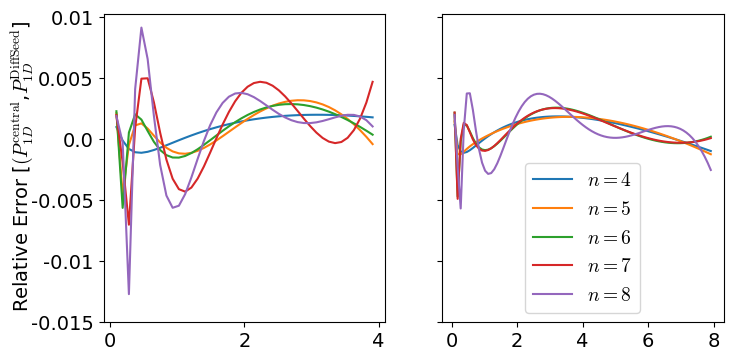

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4), sharex=False, sharey=True)
for i in range(5):
    degree = i + 4
    ax[0].plot(kMpc_4,diff_z_4[i], label =f'$n={degree}$')
    ax[1].plot(kMpc_8,diff_z_8[i], label =f'$n={degree}$')
ax[1].legend()
ax[1].set_xticks(np.arange(0,8.1,2))
ax[0].set_yticks(np.arange(-0.015,0.011,0.005))
ax[0].set_yticklabels(np.round(np.arange(-0.015,0.011,0.005),3))

#fig.text(0.45, 0, r'$k$ [1/Mpc]', va='center', rotation='horizontal', fontsize = 15)
fig.text(0.008, 0.5, r'Relative Error [$(P^{\rm central}_{1D}$,$P^{\rm DiffSeed}_{1D}$]', va='center', rotation='vertical', fontsize=14)

plt.savefig('Polynomial_order.pdf', bbox_inches='tight')

In [ ]:
for i in range(6):
    row = i // 3
    col = i % 3
    ax[row,col].plot(kMpc, diff_z[i,:])
    #ax[row,col].fill_between(kMpc, -1, 1, alpha=0.2, color='gray')
        
    degree = i + 4
    title = f'Polynomial Degree = {degree}'
    ax[row,col].set_title(title)
    
    
    if row == 1:
        ax[row,col].set_xlabel(r'$k$ [1/Mpc]')
    #if col == 0:
        #ax[row,col].set_ylabel('Poly-P1D central - Poly-P1D DiffSeed')

fig.text(0, 0.5, '(Poly-P1D central - Poly-P1D DiffSeed) / mean P1D', va='center', rotation='vertical')
plt.tight_layout()
plt.show()

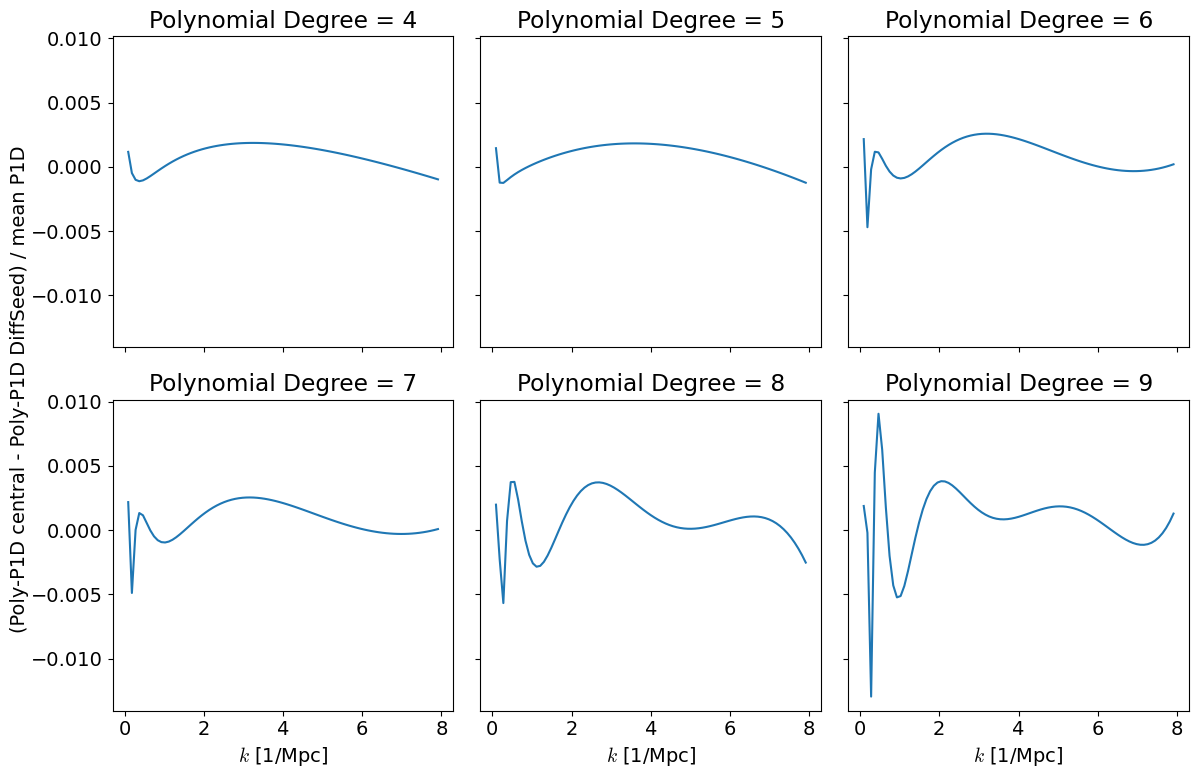

In [119]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,8), sharex=True, sharey=True)

for i in range(6):
    row = i // 3
    col = i % 3
    ax[row,col].plot(kMpc, diff_z[i,:])
    #ax[row,col].fill_between(kMpc, -1, 1, alpha=0.2, color='gray')
        
    degree = i + 4
    title = f'Polynomial Degree = {degree}'
    ax[row,col].set_title(title)
    
    
    if row == 1:
        ax[row,col].set_xlabel(r'$k$ [1/Mpc]')
    #if col == 0:
        #ax[row,col].set_ylabel('Poly-P1D central - Poly-P1D DiffSeed')

fig.text(0, 0.5, '(Poly-P1D central - Poly-P1D DiffSeed) / mean P1D', va='center', rotation='vertical')
plt.tight_layout()
plt.show()


In [ ]:
p1d_fit_err_k= p1d_fit_err_z.mean(0)

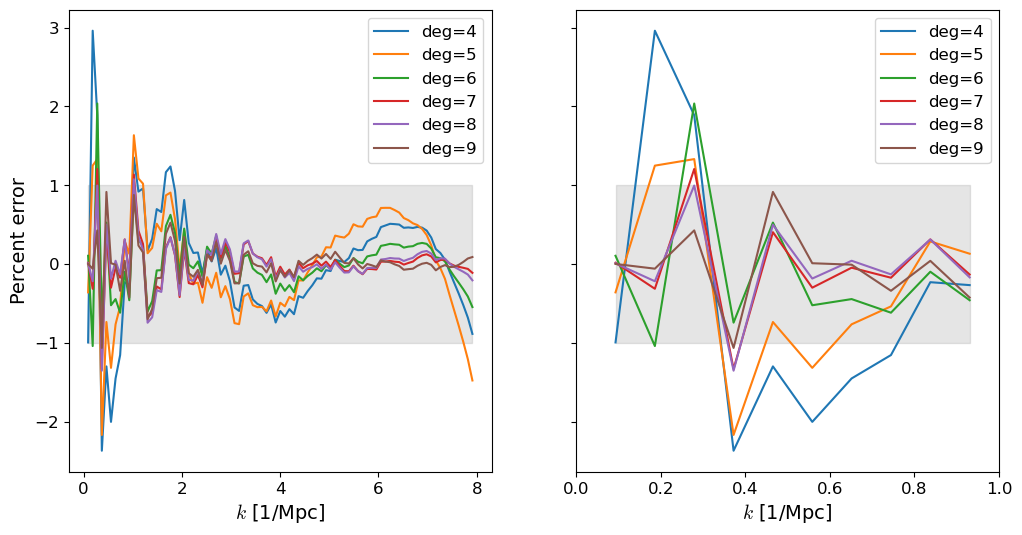

In [86]:
import matplotlib.pyplot as plt

# Create the main plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
for i in range(6):
    ax1.plot(kMpc, p1d_fit_err_k[i,:], label=f'deg={i+4}')
ax1.fill_between(kMpc, -1, 1, alpha=0.2, color='gray')
ax1.legend(fontsize=12)
ax1.set_xlabel(r'$k$ [1/Mpc]')
ax1.set_ylabel('Percent error')

# Create the subplot for k < 1
for i in range(6):
    ax2.plot(kMpc[kMpc < 1], p1d_fit_err_k[i, kMpc < 1], label=f'deg={i+4}')
ax2.fill_between(kMpc[kMpc < 1], -1, 1, alpha=0.2, color='gray')
ax2.legend(fontsize=12)
ax2.set_xlabel(r'$k$ [1/Mpc]')
ax2.set_xlim(0, 1)


# Show the plot
plt.show()


In [111]:
from lace.emulator import poly_p1d

kmax_Mpc_test= 8
Nsim=30
p1ds_fit = np.zeros(shape=(30,11,6,86))
p1ds_true = np.zeros(shape=(30,11,86))

for simnum in range(Nsim):
    
    truth=pd_archive.archivePD(z_max=4.5,pick_sim=simnum)
    truth.average_over_samples(flag="all")
    truth = [d for d in truth.data_av_all if d['ind_tau'] == 0] 
    
    for aa,item in enumerate(truth):
    
        kMpc =item["k_Mpc"]
        k_mask=(kMpc<kmax_Mpc_test)#&(kMpc>0)
        true_p1d=item["p1d_Mpc"][k_mask]#[:self.Nk_test]

        kMpc = kMpc[k_mask]
        
        p1ds_true[simnum,aa] = true_p1d

        for d in range(4,10):

            fit_p1d = poly_p1d.PolyP1D(kMpc,true_p1d, kmin_Mpc=1.e-3,kmax_Mpc=kmax_Mpc_test,deg=d)
            true_p1d_fit = fit_p1d.P_Mpc(kMpc)
            
            p1ds_fit[simnum, aa, d-4] = true_p1d_fit
            
        

Text(0, 0.5, 'Poly P1D')

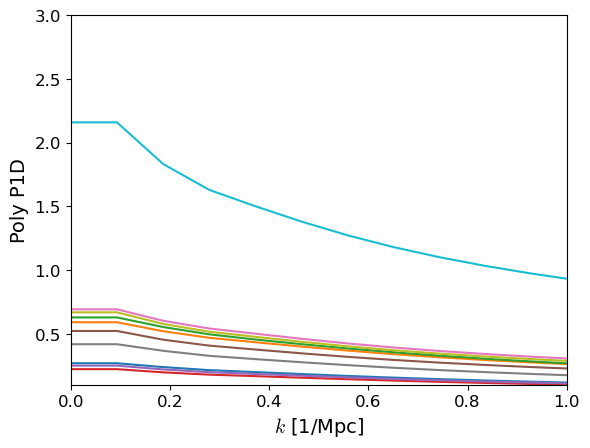

In [127]:
for i,j in zip(np.random.randint(0,30,10),np.random.randint(0,11,10)):
    plt.plot(kMpc,p1ds_fit[i,j,-1])
plt.xlim(0,1)
plt.ylim(0.1,3)
plt.xlabel(r'$k$ [1/Mpc]')
plt.ylabel(r'Poly P1D')
